# MIE1613 Project Experiment #7 - Rank-Choice Opitimization using Rinotts
Here I use the simulation to answer question 3 of the report: <i>What might optimal future hosuing construction look like</i> <br>
In experiment six I tried to use gradient estimators to analyze the continuous ratio, but the finite difference was not working well. Here I pick some select ratios and see it Rinnotts can do better

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Import
The simulation object and the required input data (emissions data and housing sample paths) <br>
<b> Important </b> -> the importer factor range is modified for sensitivity analysis: there are three values: min, most likely, max.

In [106]:
# Simulation object
from packages.project_package.mie_importer import *
from packages.project_package.mie_simulation import *

In [126]:
# Emissions data
Impr = MIEImporter()
Impr.factor_range = 'max'

Impr.e_path = 'data/input_data/embodied_'+Impr.factor_range+'_conservative.csv'
Impr.o_path = 'data/input_data/operational_intensity_2020_2050.csv'
embodied_data, operational_data = Impr.import_emission_data()

# Housing sample paths: 6000 exist for each scenario.
starts_data_hg10 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_hg10.csv', index_col=0)

Importer created. Change self.factor_range for sensitivity analysis before importing.


In [108]:
# init
Simr = MIESimulation()
Simr.e_data = embodied_data
Simr.o_data = operational_data
# share of low, middle, high: BAU construction in canada is around 40%, 30%, 30% (see FIG bau)
Simr.nlmh = np.array([0.4, 0.3, 0.3])

# init single path for cumulative
years = np.arange(2023, 2040)
starts_hg = starts_data_hg10.loc[Simr.seed,'2023':'2050'].values.astype(int)

Sim object created. Initialize self.e_data and self.o_data


## Rinott's Combined with Subset Selection
Trying to optimize the ratio from exp_6 using Rinotts procedure instead. I choose a range of ratios and run them. I adapted function from NSGS_inclass.ipynb exercise from class.

In [109]:
from scipy.stats import expon, norm, chi2, t

Put the simulation in a general function

In [110]:
def MySim(years, starts, ratio, n):
    """
    Return iteration of cumulative simulation
    with its fixed seed.
    years = range of years to sim.
    starts = # houses = len(range years).
    ratio = ratio of missing middle to mid/high rise homes.
    n = number of replications.
    """
    
    # CRN
    np.random.seed(Simr.seed)

    # ratio
    l = 0
    r_mh = ratio # m/h
    lmh = np.array([l, (1-l)*r_mh, (1-l)*(1-r_mh)])
    Simr.nlmh = lmh

    # performed the simulation n times
    thetas = np.zeros(n)
    for j in range(n):
        results = Simr.chain_periods_build_lmh(years, starts)
        theta = np.array(results['E_e'])*1e-9 + np.array(results['E_o'])*1e-9
        theta = theta.sum()

        thetas[j] = theta
    
    # Rinnot's maximizes; return negative theta
    return -thetas

In [111]:
for r in np.linspace(0,1,10):#[0,0.25,0.5,0.75,1]:
    print(r, MySim(years, starts_hg, ratio=r, n=10).mean())

0.0 -219.5198759381231
0.1111111111111111 -230.59324135009925
0.2222222222222222 -241.6734321808185
0.3333333333333333 -252.75208412458423
0.4444444444444444 -263.83193494594764
0.5555555555555556 -274.91334162767464
0.6666666666666666 -285.99101964326115
0.7777777777777777 -297.07159927322544
0.8888888888888888 -308.1440318318631
1.0 -319.21465774570345


Rinnott's procedure

In [112]:
def Rinotth(k, n0, pstar, conf, rep):
    np.random.seed(13)

    Z = np.random.randn((k-1) * rep).reshape(rep, k-1)
    Y = chi2.rvs(n0 - 1., size=((k-1) * rep)).reshape(rep, k-1)
    C = chi2.rvs(n0 - 1., size=rep).reshape(rep, 1)
    Cmat = np.tile(C, (1, k-1))

    denom = np.sqrt((n0 - 1.) * (1./Y + 1./Cmat))
    H = np.sort(np.apply_along_axis(np.max, 1, Z * denom))
    Hstar = np.quantile(H, pstar)
    
    upper_index = int(np.ceil(pstar * rep + norm.ppf(conf) * np.sqrt(pstar * (1. - pstar) * rep) + 0.5)) - 1
    Hupper = H[min(upper_index, len(H)-1)]  # Ensure index does not exceed array bounds

    return {'h': Hstar, 'UCB': Hupper}

# Example usage
# result = Rinotth(5, 10, 0.9, 0.95, 100)
# print(result)

def Rinott(k_sub, alpha, n0, delta, subset_loop):
    h_dict = Rinotth(k_sub, n0, 1-alpha, 0.99, 10000)
    h = h_dict['UCB']  # Extracting the UCB value from the dictionary

    Ybar = []
    Vars = []
    Ns = []

    for x in subset_loop:
        Y = MySim(x, n0)
        S2 = np.var(Y, ddof=1)
        N = int(np.ceil(h**2 * S2 / delta**2))

        if N > n0:
            Y = np.append(Y, MySim(x, N-n0))

        Ybar.append(np.mean(Y))
        Vars.append(S2)
        Ns.append(max(N, n0))

    Best = np.argmax(Ybar) + 1  # +1 because Python is zero-indexed

    return {'Best': Best, 'Ybar': Ybar, 'Var': Vars, 'N': Ns}


def subset_crn(k, alpha, n, years, starts):
    """
    Function to do subset selection with Common Random Numbers (CRN).
    """
    #Yall = np.array([MySim(x, n, seed) for x in range(1, k+1)]).T
    Yall = np.array([MySim(years=years, starts=starts, ratio=x, n=n) for x in np.linspace(0,1,k)]).T
    Ybar = Yall.mean(axis=0)
    
    S2 = np.cov(Yall, rowvar=False) / n
    tval = t.ppf(1-alpha/(k-1), df=n-1)
    Subset = np.arange(1, k+1)
    for i in range(k):
        for j in range(k):
            if Ybar[i] < (Ybar[j] - tval * np.sqrt(S2[i, i] + S2[j, j] - 2*S2[i, j])):
                Subset[i] = 0
                break
    return {'Subset': Subset[Subset != 0], 'Ybar': Ybar, 'S2': S2, 'corr': np.corrcoef(Yall, rowvar=False)}

Perform for different years

In [113]:
years = np.arange(2023, 2040)

# run subset crn
subset_dict = subset_crn(k=5, alpha=0.025, n=100, years=years, starts=starts_hg)
subset_res = subset_dict['Subset']
print('subset complete')

subset complete


In [114]:
subset_res
subset_dict

{'Subset': array([1]),
 'Ybar': array([-219.51642881, -244.44222967, -269.36348878, -294.2882367 ,
        -319.20767154]),
 'S2': array([[6.77998110e-06, 8.45313230e-06, 1.02533760e-05, 1.18282412e-05,
         1.44068396e-05],
        [8.45313230e-06, 1.15997324e-05, 1.32686673e-05, 1.50781016e-05,
         1.79651205e-05],
        [1.02533760e-05, 1.32686673e-05, 1.70273968e-05, 1.87656400e-05,
         2.17672050e-05],
        [1.18282412e-05, 1.50781016e-05, 1.87656400e-05, 2.19526726e-05,
         2.51241777e-05],
        [1.44068396e-05, 1.79651205e-05, 2.17672050e-05, 2.51241777e-05,
         3.06344536e-05]]),
 'corr': array([[1.        , 0.95318992, 0.95428592, 0.96953218, 0.99965331],
        [0.95318992, 1.        , 0.94412434, 0.94488506, 0.95301795],
        [0.95428592, 0.94412434, 1.        , 0.97061177, 0.95306708],
        [0.96953218, 0.94488506, 0.97061177, 1.        , 0.96881998],
        [0.99965331, 0.95301795, 0.95306708, 0.96881998, 1.        ]])}

In [127]:
years = np.arange(2023, 2025)

# run subset crn
subset_dict_2025 = subset_crn(k=5, alpha=0.025, n=100, years=years, starts=starts_hg)
subset_res_2025 = subset_dict_2025['Subset']
print('subset complete')

subset complete


In [129]:
years = np.arange(2023, 2030)

# run subset crn
subset_dict_2030 = subset_crn(k=5, alpha=0.025, n=100, years=years, starts=starts_hg)
subset_res_2030 = subset_dict_2030['Subset']
print('subset complete')

subset complete


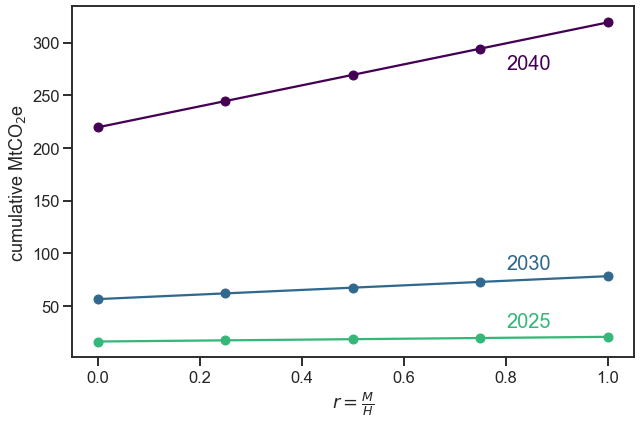

In [146]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot([x for x in np.linspace(0,1,5)], -subset_dict['Ybar'], marker='o',
        color='#440154')
ax.plot([x for x in np.linspace(0,1,5)], -subset_dict_2030['Ybar'], marker='o',
        color='#31688e')
ax.plot([x for x in np.linspace(0,1,5)], -subset_dict_2025['Ybar'], marker='o',
        color='#35b779')

ax.text(0.8,275,'2040', fontsize=20, color='#440154')
ax.text(0.8,85,'2030', fontsize=20, color='#31688e')
ax.text(0.8,30,'2025', fontsize=20, color='#35b779')
#ax[1].scatter(subset_res, -np.array(rinott_res['Ybar']))

t_list = ['subset algo', "Rinnot's algo"]
#ax.set_title(t_list[i])
ax.set_ylabel('cumulative MtCO$_2$e')
ax.set_xlabel('$r=\\frac{M}{H}$')

plt.tight_layout()
#plt.savefig('optimization_space.png', bbox_inches='tight')